In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow
import tqdm
import glob

from tqdm import tqdm

from skimage.io import imread, imshow
# from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
import seaborn as sns

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = glob.glob('/content/drive/MyDrive/Waste_Control_Data/TRAIN/O/*.jpg')
a = len(train_path)
a

4863

In [ ]:
train_r = glob.glob('/content/drive/MyDrive/Waste_Control_Data/TRAIN/R/*.jpg')
b = len(train_r)
b

4477

In [3]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory ='/content/drive/My Drive/Waste_Control_Data/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128,
                                                   subset = 'training')

Found 7473 images belonging to 2 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/Waste_Control_Data/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 1867 images belonging to 2 classes.


In [6]:
# Class Indices
train_dataset.class_indices

{'O': 0, 'R': 1}

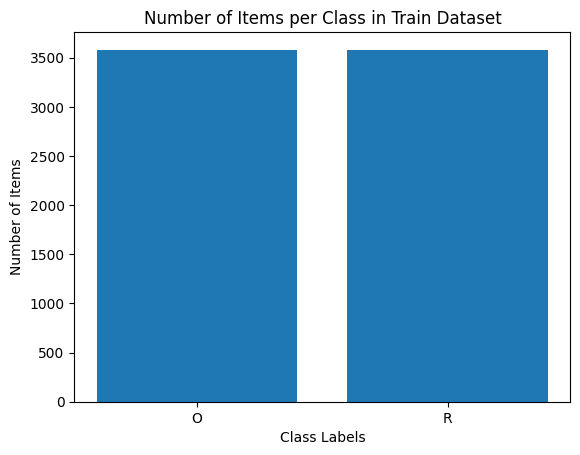

In [7]:
# Count the number of items for each label in the train dataset
train_labels_count = train_dataset.labels.sum(axis=0)

# Get the class labels
class_labels = train_dataset.class_indices.keys()

# Plot the bar graph
plt.bar(class_labels, train_labels_count)
plt.xlabel('Class Labels')
plt.ylabel('Number of Items')
plt.title('Number of Items per Class in Train Dataset')
plt.show()


In [8]:
# Define ResNet50 base model
base_model = ResNet50(input_shape=(224, 224, 3),
                       include_top=False,
                       weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [9]:
# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
#summary
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [11]:
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                       

In [13]:
# Model Compile
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

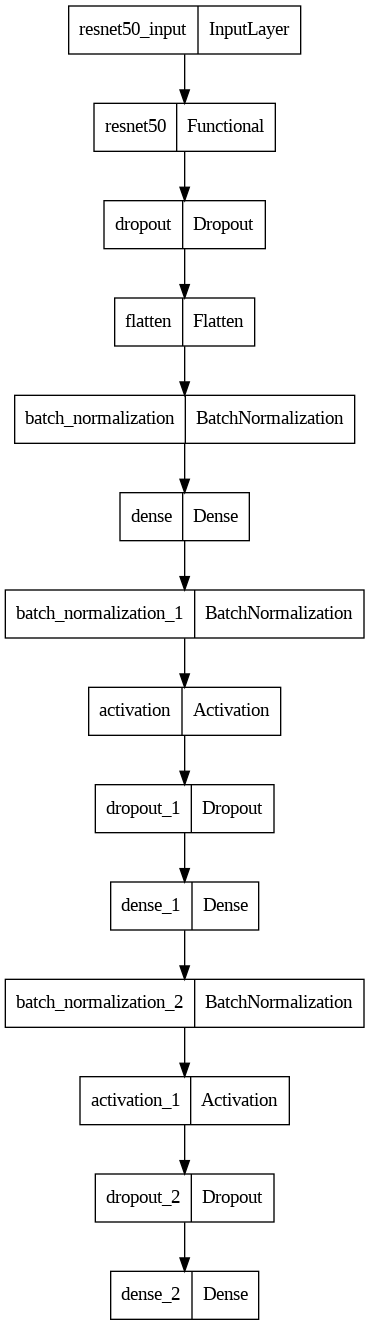

In [14]:
# Define Callbacks
filepath = './model_resnet.h5'

earlystopping = EarlyStopping(monitor='val_auc',
                              mode='max',
                              patience=5,
                              verbose=1)

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_auc',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

callback_list = [earlystopping, checkpoint]

# Plot the model architecture
plot_model(model, to_file='model_resnet.png')



In [15]:
# Model Training
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=15,
                    callbacks=callback_list,
                    verbose=1)



Epoch 1/15
59/59 [==============================] - ETA: 0s - loss: 0.5968 - auc: 0.7944 
Epoch 1: val_auc improved from -inf to 0.83300, saving model to ./model_resnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 1331s 22s/step - loss: 0.5968 - auc: 0.7944 - val_loss: 0.5525 - val_auc: 0.8330
Epoch 2/15
59/59 [==============================] - ETA: 0s - loss: 0.4954 - auc: 0.8482
Epoch 2: val_auc improved from 0.83300 to 0.84798, saving model to ./model_resnet.h5
59/59 [==============================] - 142s 2s/step - loss: 0.4954 - auc: 0.8482 - val_loss: 0.5048 - val_auc: 0.8480
Epoch 3/15
59/59 [==============================] - ETA: 0s - loss: 0.4772 - auc: 0.8583
Epoch 3: val_auc did not improve from 0.84798
59/59 [==============================] - 134s 2s/step - loss: 0.4772 - auc: 0.8583 - val_loss: 0.5642 - val_auc: 0.8164
Epoch 4/15
59/59 [==============================] - ETA: 0s - loss: 0.4504 - auc: 0.8735
Epoch 4: val_auc did not improve from 0.84798
59/59 [==============================] - 134s 2s/step - loss: 0.4504 - auc: 0.8735 - val_loss: 0.5275 - val_auc: 0.8408
Epoch 5/15
59/59 [==============================] - ETA: 0s - loss: 0.4387

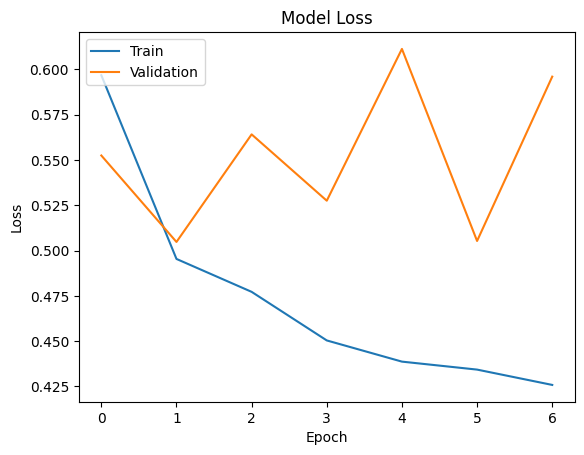

In [16]:
# Summarize model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


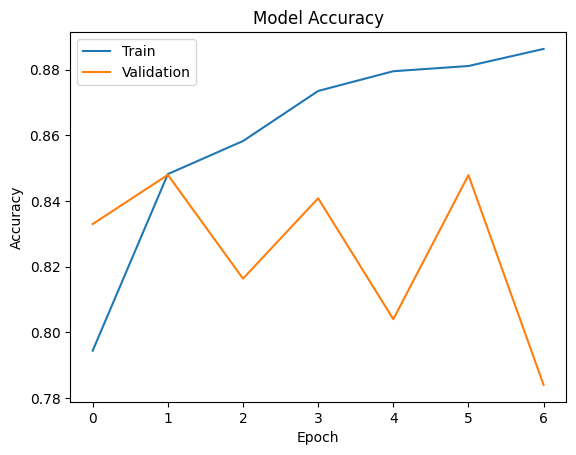

In [17]:
# Summarize model accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [18]:
# Test Data
test_data = test_datagen.flow_from_directory(directory='/content/drive/MyDrive/Waste_Control_Data/TEST',
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=128)


Found 1956 images belonging to 2 classes.


In [19]:
# evaluationg loss and Auc of test data
model.evaluate(test_data)

16/16 [==============================] - 270s 18s/step - loss: 0.4918 - auc: 0.8482


[0.4917667508125305, 0.8481910228729248]

1/1 [==============================] - 3s 3s/step
The image belongs to Organic waste category 


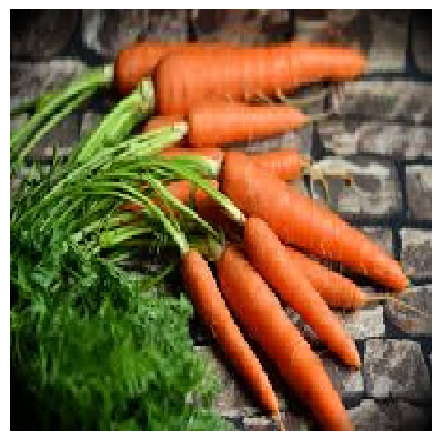

In [20]:
# Test Case:1 - ORGANIC
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Waste_Control_Data/TEST/O/O_12701.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

1/1 [==============================] - 0s 57ms/step
The image belongs to Recycle waste category


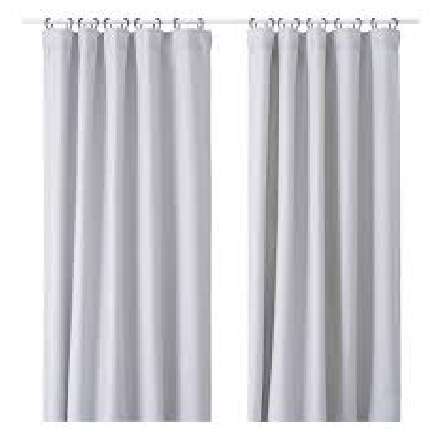

In [21]:
# Test Case:2 - RECYCLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Waste_Control_Data/TEST/R/R_10004.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

In [23]:
test_data.reset()  # Reset generator to start of dataset
y_true = test_data.classes
y_pred = model.predict(test_data)
# y_pred_classes = np.argmax(y_pred, axis=1)

16/16 [==============================] - 11s 646ms/step


In [24]:
binary_values = (y_pred >= 0.5).astype(int)


In [25]:
reshaped_array = binary_values.reshape(1956)

In [26]:
reshaped_array.shape


(1956,)

In [27]:
y_true.shape

(1956,)

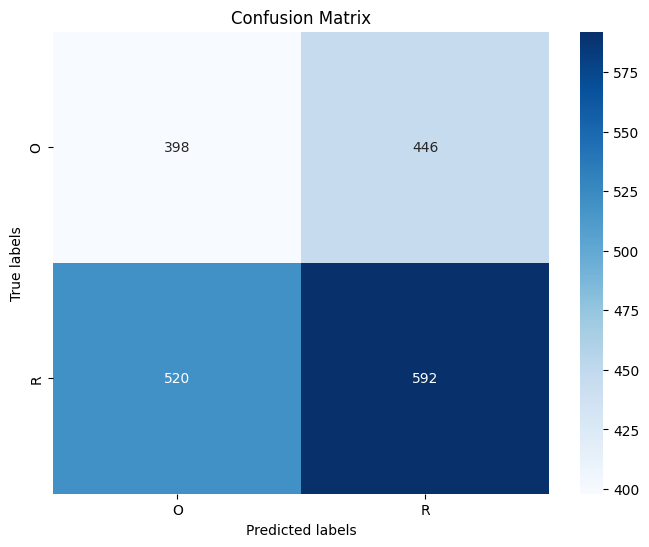

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, reshaped_array)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [29]:
binary_values_test = (y_pred >= 0.5).astype(int)

In [30]:
# Calculate Precision, Recall, F1 Score
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, binary_values_test, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.5113095348926268
Recall: 0.5061349693251533
F1 Score: 0.508006501775162
